<a href="https://colab.research.google.com/github/nhquynhhh/IS403_O21_2/blob/week8_hoangmanhthang/Model/FEDformer/DXG_FEDformer_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuralforecast

In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from neuralforecast import NeuralForecast
from neuralforecast.models import FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pre_ADA-USD.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df['unique_id'] = 'ADA'
df = df.rename(columns={'Close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].astype(float)
df = df[['unique_id', 'Date', 'Price']]
df

,unique_id,Date,Price
0,ADA,2018-03-01,0.304397
1,ADA,2018-03-02,0.293504
2,ADA,2018-03-03,0.297106
3,ADA,2018-03-04,0.300787
4,ADA,2018-03-05,0.297622
...,...,...,...
2280,ADA,2024-05-28,0.456990
2281,ADA,2024-05-29,0.450995
2282,ADA,2024-05-30,0.446581
2283,ADA,2024-05-31,0.447461


In [5]:
df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df

,unique_id,ds,y
0,ADA,2018-03-01,0.304397
1,ADA,2018-03-02,0.293504
2,ADA,2018-03-03,0.297106
3,ADA,2018-03-04,0.300787
4,ADA,2018-03-05,0.297622
...,...,...,...
2280,ADA,2024-05-28,0.456990
2281,ADA,2024-05-29,0.450995
2282,ADA,2024-05-30,0.446581
2283,ADA,2024-05-31,0.447461


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2285 non-null   object        
 1   ds         2285 non-null   datetime64[ns]
 2   y          2285 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 53.7+ KB


In [7]:
train_data = df[:int(0.9 * int(len(df)))]
test_data = df[int(0.9 * int(len(df))):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 2056
Test lenght: 229


In [23]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [8]:
from neuralforecast.models import FEDformer
model = FEDformer(h=test_len+90,
                 input_size=300,
                 modes=64,
                 hidden_size=128,
                 n_head=8,
                 scaler_type='standard',
                 learning_rate=1e-3,
                 max_steps=200,
                 batch_size=32,
                 windows_batch_size=256
                )

nf = NeuralForecast(
    models=[model],
    freq='D',
)
nf.fit(df=train_data, static_df=None, verbose=True)
forecasts = nf.predict()



INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 279 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [9]:
train = train_data['y']
test = test_data['y']


train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [10]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]


In [11]:
print(predict_test.isna().sum())

0


In [12]:
predict_test

0      0.349176
1      0.329543
2      0.316742
3      0.308295
4      0.294525
         ...   
224    0.308559
225    0.311654
226    0.317118
227    0.338455
228    0.344042
Name: FEDformer, Length: 229, dtype: float32

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.2423757108065176
Mean Absolute Percentage Error (MAPE): 44.10252133532802
Root Mean Square Error (RMSE): 0.2720415373648205


In [14]:
# adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)


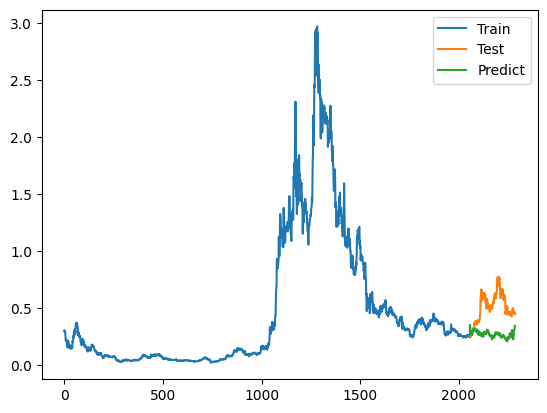

In [15]:
train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(predict_test_index,(predict_test))
plt.legend(['Train','Test','Predict'])
plt.show()



In [16]:
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]


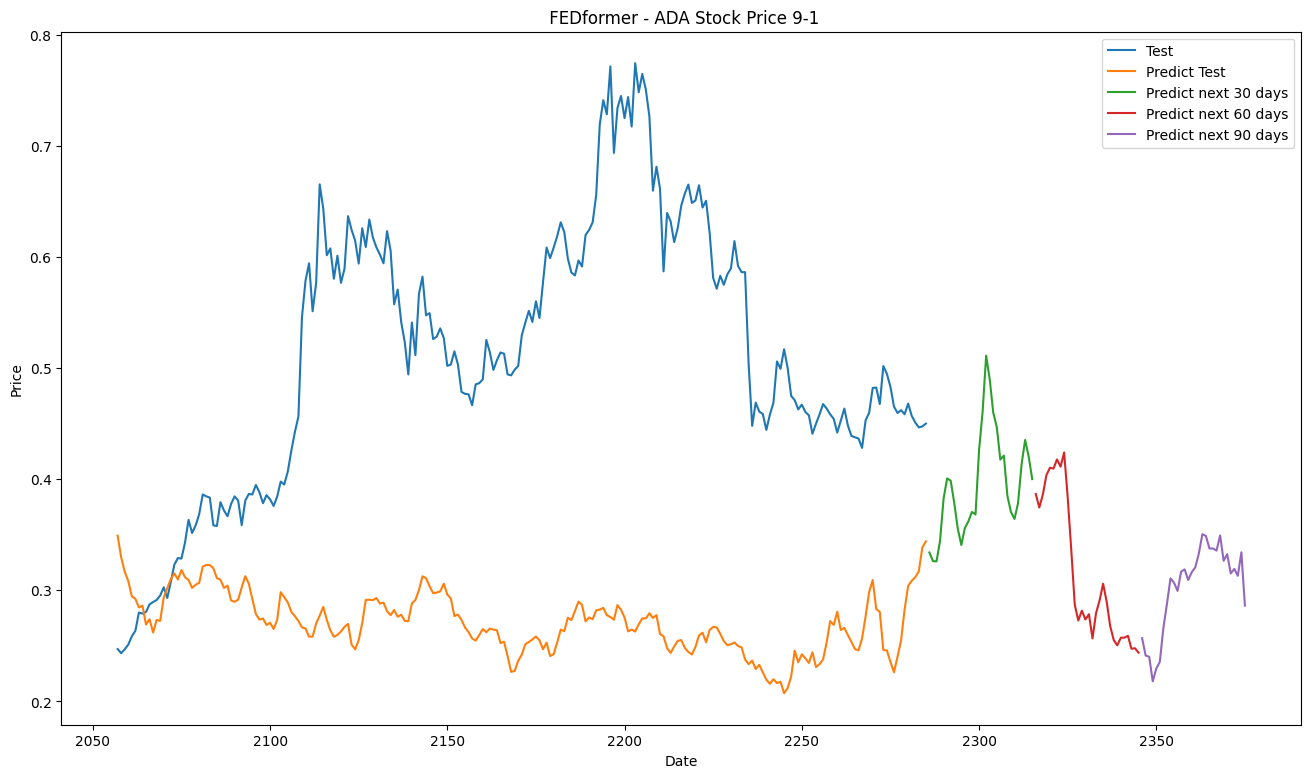

In [18]:
plt.figure(figsize=(16, 9))
# train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
# plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))
predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)
plt.legend([ 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(' FEDformer - ADA Stock Price 9-1')
plt.show()
